In [1]:
%load_ext nb_black
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

In [2]:
from util.data import load_mnist, encode_data
import numpy as np
import matplotlib.pyplot as plt
from algorithms.SaccadeGenerator import SaccadeGenerator
import tensorflow as tf
from tqdm.notebook import tqdm

<IPython.core.display.Javascript object>

In [3]:
(x_train, y_train), (x_test, y_test) = load_mnist()
x_train, x_test = encode_data(x_train, x_test)

<IPython.core.display.Javascript object>

In [4]:
x_train.shape

(60000, 28, 28)

<IPython.core.display.Javascript object>

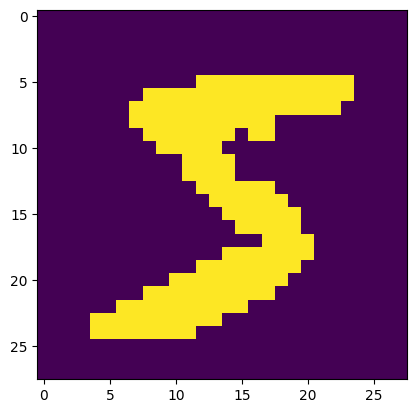

<IPython.core.display.Javascript object>

In [5]:
plt.imshow(x_train[0])

In [6]:
from util.math import get_random_pool_indices
from util.plots import plot_image_with_saccade

<IPython.core.display.Javascript object>

In [7]:
# plot_image_with_saccade(x_train[saccades[3]["data_index"]], saccades[3]["indices"])

<IPython.core.display.Javascript object>

In [8]:
def get_model() -> tf.keras.Model:
    model = tf.keras.models.Sequential(
        [
            tf.keras.layers.Input(
                shape=[
                    5,
                    128,
                ],
                batch_size=128,
            ),
            tf.keras.layers.LSTM(128, return_sequences=True),
            tf.keras.layers.LSTM(64),
            tf.keras.layers.Dense(10),
        ]
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(0.001),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    )

    return model


def fit_model(epochs=5):
    train_gen = SaccadeGenerator(x_train, y_train, (5, 5), 10)
    val_gen = SaccadeGenerator(x_test, y_test, (5, 5), 10)

    model = get_model()

    history = model.fit(
        train_gen, batch_size=128, validation_data=val_gen, epochs=epochs
    )

    return model, history

<IPython.core.display.Javascript object>

In [ ]:
model, history = fit_model(20)

In [ ]:
val_gen = SaccadeGenerator(x_test, y_test, (5, 5), 10)

model.evaluate(val_gen)

In [9]:
from algorithms import SpatialPooler

<IPython.core.display.Javascript object>

In [23]:
COLUMN_SPARSITY = 0.2
COLUMN_DIM = (128,)
INP_SHAPE = (25, 1)

sp = SpatialPooler(
    input_dimension=INP_SHAPE,
    column_dimension=COLUMN_DIM,
    connection_sparsity=1,
    permanence_threshold=0.5,
    stimulus_threshold=1.0,
    permanence_increment=0.1,
    permanence_decrement=0.02,
    column_sparsity=COLUMN_SPARSITY,
    potential_pool_radius=5,
    boost_strength=50,
)

<IPython.core.display.Javascript object>

In [24]:
def get_sp_union_data(x, y, learn):
    train_gen = SaccadeGenerator(x, y, (5, 5), 5)
    activations = np.zeros(shape=(x.shape[0], 5, 128))
    
    for idx, obj in enumerate(tqdm(train_gen, total=len(train_gen))):

        for mov_idx, movement in enumerate(obj):
            feature = movement['feature']

            wc = sp.compute(feature, learn=learn)
            sdr = sp.top_columns_to_sdr(wc)
        

            activations[idx,mov_idx] = sdr
    
    return activations, y
    


<IPython.core.display.Javascript object>

In [25]:
act, y = get_sp_union_data(x_train, y_train, True)
act_test, y_test = get_sp_union_data(x_test, y_test, False)

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

In [26]:
ds_train = tf.data.Dataset.from_tensor_slices((act, y))
ds_test = tf.data.Dataset.from_tensor_slices((act_test, y_test))

ds_train = ds_train.batch(128, drop_remainder=True)
ds_test = ds_test.batch(128, drop_remainder=True)

<IPython.core.display.Javascript object>

In [27]:
model = get_model()
history = model.fit(ds_train, batch_size=128, validation_data=ds_test, epochs=20)

Epoch 1/20


2023-01-28 22:42:41.481342: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-28 22:42:41.595592: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-28 22:42:41.647965: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  1/468 [..............................] - ETA: 12:17 - loss: 2.3041 - sparse_categorical_accuracy: 0.0781

2023-01-28 22:42:41.709360: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-28 22:42:41.789202: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


464/468 [============================>.] - ETA: 0s - loss: 2.3020 - sparse_categorical_accuracy: 0.1094

2023-01-28 22:42:47.921445: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-28 22:42:47.970695: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-28 22:42:48.010445: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


468/468 [==============================] - 8s 14ms/step - loss: 2.3020 - sparse_categorical_accuracy: 0.1093 - val_loss: 2.3016 - val_sparse_categorical_accuracy: 0.1076
Epoch 2/20
468/468 [==============================] - 6s 13ms/step - loss: 2.2997 - sparse_categorical_accuracy: 0.1145 - val_loss: 2.3024 - val_sparse_categorical_accuracy: 0.1067
Epoch 3/20
468/468 [==============================] - 6s 13ms/step - loss: 2.2982 - sparse_categorical_accuracy: 0.1162 - val_loss: 2.3045 - val_sparse_categorical_accuracy: 0.1038
Epoch 4/20
468/468 [==============================] - 6s 13ms/step - loss: 2.2958 - sparse_categorical_accuracy: 0.1200 - val_loss: 2.3088 - val_sparse_categorical_accuracy: 0.0997
Epoch 5/20
468/468 [==============================] - 6s 13ms/step - loss: 2.2914 - sparse_categorical_accuracy: 0.1251 - val_loss: 2.3149 - val_sparse_categorical_accuracy: 0.1016
Epoch 6/20
468/468 [==============================] - 6s 13ms/step - loss: 2.2833 - sparse_categorical_acc

<IPython.core.display.Javascript object>